Some functions defined in DM detection around BH paper (Nickles):

In [1]:
import scipy.stats as st
import scipy.constants as sc
import numpy as np
import random

from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
G        = sc.gravitational_constant
c        = sc.speed_of_light
m_1      = 10^4             # solar mass of intermediate mass black hole


rho_sp   = 226              # solar mass / pc**3
gamma_sp = 7/3              # slope parameter


# r_in   = 5.906*10**7      # meters, ASSUMING gamma_sp = 7/3
r_in     = 1.914*10**-9     # "Parsecs"

# r_sp   = 3.61324*10**16   # meters, ASSUMING gamma_sp = 7/3
r_sp     = 1.17097          # "Parsecs"

In [3]:
def m_dm(r):
    m_dm = ((4*sc.pi*rho_sp*r_sp**gamma_sp)
            /(3-gamma_sp))*r**(3-gamma_sp)
    return m_dm

In [4]:
def m_enc(r):
        m_enc = (m_dm(r) - m_dm(r_in))
        return m_enc

In [5]:
def dark_matter_dist(r):
        rho_dm = rho_sp*(r_sp/r)**gamma_sp
        return rho_dm*r**2

Let's test out a few of these functions:

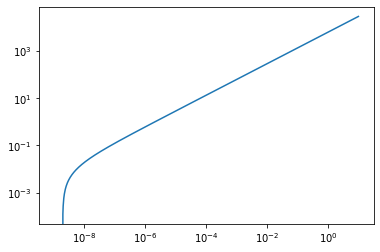

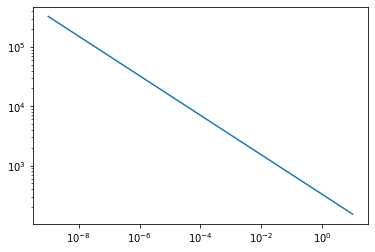

In [6]:
# Let's assort a logspace array of radii from r_in to r_sp limits, roughly.
radius  = np.logspace(-9,1,num=1000) 


# Calculate the DM mass for each radii.
mass    = []
for _ in radius:
    mass.append(m_enc(_))
m       = plt.figure(1)
plt.loglog()
plt.plot(radius,mass)

# And now for the dark-matter distribution:
density = []
for _ in radius:
    density.append(dark_matter_dist(_))
d       = plt.figure(2)
plt.loglog()
plt.plot(radius,density)

Weighted Sampling from DM Density Function for radii:

In [7]:
def sample_cdf(pdf, xmin, xmax, n_bins=1000, log=False):
    if log:
        binner = np.geomspace
    else:
        binner = np.linspace
    edges = binner(xmin, xmax, n_bins)
    bins = np.vstack((edges[:-1], edges[1:])).T
    centers = np.mean(bins, axis=1)
    widths = bins[:, 1] - bins[:, 0]
    pdf_samples = pdf(centers)
    cdf_samples = np.cumsum(pdf_samples * widths)
    cdf_samples /= cdf_samples[-1]
    return np.vstack((centers, cdf_samples)).T

def inverse_cdf(*args, **kwargs):
    iy, ix = sample_cdf(*args, **kwargs).T
    return interp1d(ix, iy, fill_value='extrapolate')

def sample(icdf, n_samples):
    range_samples = np.random.uniform(size=n_samples)
    return icdf(range_samples)

In [8]:
%%time
def pdf(r):
    rho_dm = rho_sp*(r_sp/r)**gamma_sp
    return rho_dm*r**2
    
icdf = inverse_cdf(pdf, 10, 1e3)
samples = sample(icdf, 1000000)

Wall time: 204 ms


[897.29747945  94.00934634  54.17464928 888.21125951  60.49833647
 377.40849663 270.60374547 111.82108074 454.05448159 618.81082066]


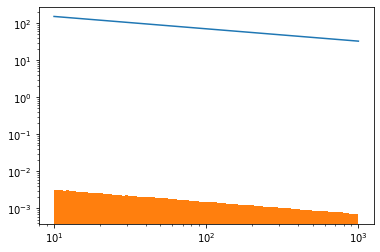

In [9]:
plt.loglog()
x = np.geomspace(10, 1e3, 100)
plt.plot(x, pdf(x))
plt.hist(samples, density=True, bins=np.geomspace(10, 1e3, 100));

samples = sample(icdf, 10)
print(samples)

Randomized cartesian coordinates for spherical DM halo:

In [10]:
def inverse_cdf(F):
    r = (r_sp**(-gamma_sp)*
         (F*r_sp**3+r_in**3*(r_sp/r_in)**gamma_sp-F*r_in**3*(r_sp/r_in)**gamma_sp))**(1/(3-gamma_sp))
    return r

In [11]:
def random_radius(sample):
    F = np.random.uniform(size=sample)
    return inverse_cdf(F)

def random_radius2():
    F = np.random.uniform(size=1)
    return inverse_cdf(F)

In [20]:
def random_vector():
    vector            = np.asarray([np.random.normal() for _ in range(3)])
    normalized_vector = vector / np.linalg.norm(vector)
#     return normalized_vector[np.newaxis,:] * random_radius(sample)[:,np.newaxis]
    return normalized_vector * random_radius(1)[0]

def random_vector2():
    vector            = [np.random.normal() for _ in range(3)]
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector * random_radius2()


In [21]:
vector = []
for i in range(3):
    vector.append(random_vector())
print(vector)


[array([-0.02024733,  0.0206419 , -0.01189042]), array([ 0.25995986,  0.15985783, -0.19295466]), array([ 0.05119321, -0.13131575, -0.0379998 ])]


Vector: [-0.01247588  0.0629863  -0.00512329]


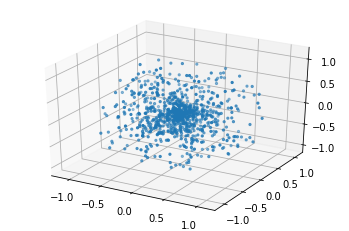

In [25]:
example_vector = random_vector()
print('Vector:', example_vector)

zdata = []
ydata = []
xdata = []

vector = []
for i in range(1000):
    vector.append(random_vector())
# print(vector)

for _ in vector:
    xdata.append(_[0])
    ydata.append(_[1])
    zdata.append(_[2])

    
ax = plt.axes(projection='3d')
ax.scatter3D(xdata,ydata,zdata,s=5);

Let's randomize the velocities of each DM particle!

In [35]:
# G        = sc.gravitational_constant
G        = 4.3*10**-3       # parsec * solarMass^-1 * (km/s)^2

# Constants need to be made sure they are in Parsecs, as the other
# constants defined are in parsec distances.

Here, we take our N(E) function, eq. (4.4), and plot it:
This defines the number of particles (y-axis) with an associated energy (x-axis).

In [77]:
from math import *

def energy(epsilon):
    num_particles =                                                \
    (G**3)*(sc.pi**(3/2))*(epsilon**(gamma_sp-4))*(m_1**3)         \
    *((r_sp/(G*m_1))**gamma_sp)*(gamma_sp-1)*(gamma_sp)*(rho_sp)   \
    *gamma(gamma_sp-1)
    
    num_particles /= gamma(gamma_sp-(1/2))
    return num_particles


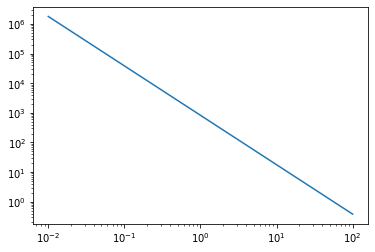

In [78]:
energies   = np.logspace(-2,2,num=100)
num_energy = []
for dE in energies:
    num_energy.append(energy(dE))
plt.loglog()
plt.plot(energies,num_energy)



Then, we must normalize our function over some epsilon_min to +inf. 
Using Mathematica, we find the following expression!

In [79]:
def norm_energy(epsilon_min):
    normFinal =                                          \
    -(G**3)*(sc.pi**(3/2))*(m_1**3)                      \
    *((r_sp/(G*m_1))**gamma_sp)*(gamma_sp-1)*(gamma_sp)  \
    *((epsilon_min)**(gamma_sp-3))*(rho_sp)              \
    *gamma(gamma_sp-1)
    
    normFinal /= ((gamma_sp-3)*(gamma(gamma_sp-(1/2))))
    return normFinal
                                               

In [90]:
epsilon_max = (G*m_1)/r_in
print(epsilon_max)

norm_energy(x) = epsilon_max

31452455.59038662


2666379.000348247